In [1]:
import getpass
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.conf.SparkConf()
# conf.setMaster('yarn')
conf.setMaster('local[2]')
conf.setAppName('twitter-{0}'.format(getpass.getuser()))
conf.set('spark.executor.memory', '4g')
conf.set('spark.executor.instances', '6')
conf.set('spark.port.maxRetries', '100')
sc = pyspark.SparkContext.getOrCreate(conf)
conf = sc.getConf()
sc

<SparkContext master=local[2] appName=twitter-sacchi>

In [2]:
spark = SparkSession(sc)

In [9]:
import getpass
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pandas import Series
import datetime
import time

import pandas as pd
import numpy as np

from scipy.stats import gamma, lognorm
import matplotlib.pylab as plt
import seaborn as sns

from pyscripts.test_utils import toy_schedule
from pyscripts.planner import *
from pyscripts.metadata import *

from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
df = spark.read.option("delimiter", ";").option("header", "true").csv('/datasets/project/istdaten/*/*')
metadataPandas = generate_metadata_pandas(spark)
# .csv('/home/marco/Downloads/2017-09')

In [28]:
# Keep only the needed information and rename
df = df.select(
          df['BETRIEBSTAG'].alias('date'), 
          df['FAHRT_BEZEICHNER'].alias('id'), 
          df['PRODUKT_ID'].alias('transport_type'), 
          df['LINIEN_ID'].alias('train_number'), 
          df['HALTESTELLEN_NAME'].alias('stop_name'), 
          df['ANKUNFTSZEIT'].alias('arrival_time'), 
          df['AN_PROGNOSE'].alias('actual_arrival_time'),
          df['AN_PROGNOSE_STATUS'].alias('status_arrival_time'),
          df['ABFAHRTSZEIT'].alias('departure_time'),
          df['AB_PROGNOSE'].alias('actual_departure_time'),
          df['AB_PROGNOSE_STATUS'].alias('status_departure_time'),
          df['DURCHFAHRT_TF'].alias('stop_here'))

# compute the departure and arrival delays
formatTS1 = "dd.MM.yyyy HH:mm:ss"
formatTS2 = "dd.MM.yyyy HH:mm"

departure_delay = (F.unix_timestamp('actual_departure_time', formatTS1) - 
        F.unix_timestamp('departure_time', formatTS2))
arrival_delay = (F.unix_timestamp('actual_arrival_time', formatTS1) - 
        F.unix_timestamp('arrival_time', formatTS2))

# extract the day of the week
def get_week_day(date):
    converted_date = datetime.datetime.strptime(str(date), "%d.%m.%Y")
    return converted_date.weekday()

week_day_udf = F.udf(get_week_day, IntegerType())

# udf to fill NaN departure (arrival) values with the arrival (departure) time
@udf('string')
def fillWithOther(a, b):
    if (a is None):
        return b
    return a
    
# date parser
date = F.to_date('date', 'dd.MM.yyyy')

# First filtering. arrival_delay and departure_delay columns
df_filtered = (df.filter((df.status_arrival_time == 'GESCHAETZT') | (df.status_departure_time == 'GESCHAETZT'))
     .withColumn("arrival_delay", arrival_delay)
     .withColumn("departure_delay", departure_delay)
                      )

# Handling the NaN values
df_with_delays = df_filtered.select('id', 'train_number', 'stop_name', 'arrival_time', 'arrival_delay', 'departure_time', 'departure_delay', 'date')
df_with_delays = df_with_delays.fillna(0, ['departure_delay', 'arrival_delay'])
df_with_delays = (df_with_delays
                  .withColumn('arrival_time2', fillWithOther(df_with_delays.arrival_time, df_with_delays.departure_time))
                  .withColumn('departure_time2', fillWithOther(df_with_delays.departure_time, df_with_delays.arrival_time))
                  .drop(df_with_delays.departure_time).drop(df_with_delays.arrival_time)
                 )
df_with_delays = df_with_delays.withColumnRenamed('departure_time2', 'departure_time').withColumnRenamed('arrival_time2', 'arrival_time')
# Adding the day of the week and the week day of the start of the trip
df_with_delays = df_with_delays.withColumn("day_week_start", week_day_udf(df_with_delays.date))
df_with_delays = df_with_delays.withColumn("day_week", week_day_udf(F.split(df_with_delays.arrival_time, " ")[0]))

# Filtering outliers
df_with_delays = df_with_delays.filter((df_with_delays['arrival_delay'] > -1000) &
                                       (df_with_delays['arrival_delay'] < 1000) &
                                       (df_with_delays['departure_delay'] > -1000) &
                                       (df_with_delays['departure_delay'] < 1000)
                                      )

df_grouped = (df_with_delays
    .filter(df_with_delays.stop_name.isin(metadataPandas.stop.tolist()))
#     .withColumn('info', F.struct('stop_name', F.split('arrival_time', " ")[1], 'arrival_delay', F.split('departure_time', " ")[1], 'departure_delay', 'day_week', 'day_week_start'))
#     .groupby('id')
#     .agg(F.collect_list('info').alias('info'))
              )

In [29]:
df_grouped.count()

2450990

In [30]:
delays = df_grouped.select('arrival_delay', 'departure_delay').toPandas()

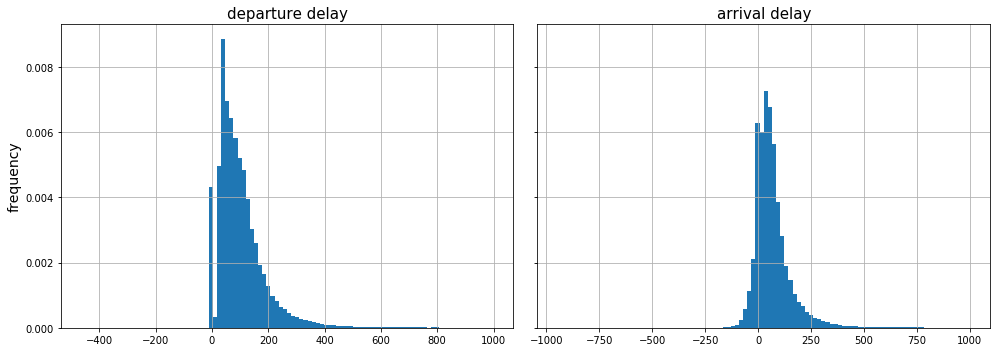

In [62]:
_, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

delays.departure_delay.plot(kind="hist", bins=100, ax=ax[0], normed=True)
delays.arrival_delay.plot(kind="hist", bins=100, ax=ax[1], normed=True)

ax[0].grid()
ax[0].set_title("departure delay", fontsize=15)
ax[0].set_ylabel("frequency", fontsize=14)

ax[1].grid()
ax[1].set_title("arrival delay", fontsize=15)

plt.tight_layout()
plt.savefig("img/delay_distributions.png")

In [ ]:
from pyspark.sql import functions as F
from pandas import Series

formatTS1 = "dd.MM.yyyy HH:mm:ss"
formatTS2 = "dd.MM.yyyy HH:mm"
# df2 = df1.withColumn('Timestamp2', F.unix_timestamp('Timestamp', format).cast('timestamp'))

departure_delay = (F.unix_timestamp('AB_PROGNOSE', formatTS1) - 
        F.unix_timestamp('ABFAHRTSZEIT', formatTS2))
arrival_delay = (F.unix_timestamp('AN_PROGNOSE', formatTS1) - 
        F.unix_timestamp('ANKUNFTSZEIT', formatTS2))

day_week = F.to_date('BETRIEBSTAG', 'dd.MM.yyyy')

limited_df_filtered = (limited_df.filter((limited_df.AN_PROGNOSE_STATUS == 'GESCHAETZT') & (limited_df.AB_PROGNOSE_STATUS == 'GESCHAETZT'))
     .withColumn("arrival_delay", arrival_delay)
     .withColumn("departure_delay", departure_delay)
     .withColumn("day_week", F.dayofweek(day_week)))

# limited_df_filtered.groupBy(['FAHRT_BEZEICHNER']).count().take(100)
(limited_df_filtered.rdd
                       .groupBy(lambda x: (x.FAHRT_BEZEICHNER, x.day_week ))
                       .map(lambda triplet: (triplet[0], list(Series(list(triplet[1]))
                                             .map(lambda stop: (stop.HALTESTELLEN_NAME, stop.ANKUNFTSZEIT, stop.AN_PROGNOSE, stop.ABFAHRTSZEIT, stop.AB_PROGNOSE)))))
                       .take(100) )


In [11]:
from pyspark.sql import functions as F
from pandas import Series

# trip_ip: FAHRT_BEZEICHNER
# delay = AN_PROGNOSE - ANKUNFTSZEIT
# HALTESTELLEN_NAME: name of the stop

collected_df = (limited_df_filtered.select('FAHRT_BEZEICHNER', 'LINIEN_ID', 'HALTESTELLEN_NAME', 'day_week', 'ANKUNFTSZEIT', 'arrival_delay', 'ABFAHRTSZEIT', 'departure_delay')
        .collect())
 #.take(10))

In [91]:
df_with_delays = limited_df_filtered.select('FAHRT_BEZEICHNER', 'LINIEN_ID', 'HALTESTELLEN_NAME', 'day_week', 'ANKUNFTSZEIT', 'arrival_delay', 'ABFAHRTSZEIT', 'departure_delay')
df_with_delays = df_with_delays.filter((df_with_delays['arrival_delay'] > -1000) &
                                       (df_with_delays['arrival_delay'] < 1000) &
                                       (df_with_delays['departure_delay'] > -1000) &
                                       (df_with_delays['departure_delay'] < 1000)
                                      )
arrival_delays = df_with_delays.select('arrival_delay').toPandas()
departure_delays = df_with_delays.select('departure_delay').toPandas()

# for x in arrival_delays.take(10):
#     print(x[0])

df_with_delays.take(10)

[Row(FAHRT_BEZEICHNER='80:07____:3041:000', LINIEN_ID='3041', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 07:42', arrival_delay=94, ABFAHRTSZEIT='27.09.2017 07:43', departure_delay=108),
 Row(FAHRT_BEZEICHNER='80:07____:3042:000', LINIEN_ID='3042', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 10:14', arrival_delay=97, ABFAHRTSZEIT='27.09.2017 10:16', departure_delay=93),
 Row(FAHRT_BEZEICHNER='80:07____:3043:000', LINIEN_ID='3043', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 09:42', arrival_delay=97, ABFAHRTSZEIT='27.09.2017 09:43', departure_delay=108),
 Row(FAHRT_BEZEICHNER='80:07____:3044:000', LINIEN_ID='3044', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 12:14', arrival_delay=155, ABFAHRTSZEIT='27.09.2017 12:16', departure_delay=114),
 Row(FAHRT_BEZEICHNER='80:07____:3045:000', LINIEN_ID='3045', HALTESTELLEN_NAME='Schaffhausen', day_week=4, ANKUNFTSZEIT='27.09.2017 11:42', arr

In [ ]:
from matplotlib.pyplot import hist

# arrival_delays[arrival_delays['arrival_delay'] < -1000] = 0
# arrival_delays[arrival_delays['arrival_delay'] > 1000] = 0

# n, bins, patches = hist(arrival_delays.arrival_delay, bins=100)
n, bins, patches = hist(df_with_delays.select('arrival_delay').collect(), bins=100)
# arrival_delays.groupby(['arrival_delay']).count()
# df_with_delays.groupby('arrival_delay').count().take(10)

# arrival_delays.max(), arrival_delays.min(), bins

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 5.00000e+00, 4.00000e+00, 7.00000e+00, 8.00000e+00,
        3.30000e+01, 3.50000e+01, 6.50000e+01, 1.25000e+02, 2.83000e+02,
        7.20000e+02, 1.13400e+03, 1.18650e+04, 6.74420e+04, 1.76305e+05,
        1.73669e+05, 1.49333e+05, 1.55885e+05, 1.36055e+05, 1.20062e+05,
        1.06690e+05, 8.25910e+04, 7.13850e+04, 5.43470e+04, 4.49540e+04,
        3.87060e+04, 2.96350e+04, 2.56620e+04, 1.95740e+04, 1.63280e+04,
        1.38330e+04, 1.04910e+04, 9.26900e+03, 6.96600e+03, 5.97900e+03,
        5.11900e+03, 4.20400e+03, 3.53000e+03, 2.82

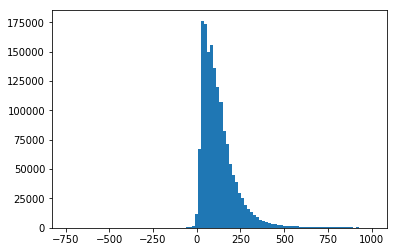

In [82]:
from matplotlib.pyplot import hist

# departure_delays[departure_delays['departure_delay'] < -1000] = 0
# departure_delays[departure_delays['departure_delay'] > 1000] = 0

hist(departure_delays.departure_delay, bins=100)

In [86]:
departure_delays.departure_delay.corr(arrival_delays.arrival_delay)

0.7774452238049401